In [1]:
import mnist
import torch
from torch import nn, optim
from torch.nn import functional as F
from tqdm import tqdm
import numpy as np
from torchvision.utils import save_image

/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_images = mnist.train_images() / 255
train_images=np.float32(train_images)
train_labels = mnist.train_labels()
test_images = mnist.test_images() / 255
test_images=np.float32(test_images)


In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc21 = nn.Linear(512, 64)
        self.fc22 = nn.Linear(512, 64)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        mu =  self.fc21(x)
        logvar = self.fc22(x)

        return mu, logvar

In [6]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 784)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def get_deep_f(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [9]:
enc = Encoder().cuda().train()
dec = Decoder().cuda().train()
dis = Discriminator().cuda().train()

optimizer_dis = optim.Adam(dis.parameters(), lr=1e-4)
optimizer_dec = optim.Adam(dec.parameters(), lr=1e-4)
optimizer_enc = optim.Adam(enc.parameters(), lr=1e-4)

criterion = nn.BCELoss()
criterion_rec = nn.MSELoss(reduction="sum")


In [10]:
train_images = train_images.reshape(-1,784)

In [ ]:
from time import time
enc_losses = []
dec_losses = []
dis_losses = []

epochs = 100
batch_size_intd = 128
X_train2 = torch.from_numpy(train_images).cuda()

for epoch in tqdm(range(1, epochs + 1)):
    start = time()
    with torch.no_grad():
        permutation = torch.randperm(X_train2.size()[0])
    for i in range(0,X_train2.size()[0], batch_size_intd):
        indices = permutation[i:i+batch_size_intd]
        if len(indices)!= 128:
            continue
        batch_x = X_train2[indices]
        batch_size = batch_x.shape[0]
        y_real = torch.ones((batch_size,1)).cuda()
        y_fake = torch.zeros((batch_size,1)).cuda()

        dis.zero_grad()
        
        dis_real_loss = criterion(dis(batch_x), y_real)
        zp = torch.randn((batch_size,64)).cuda()
        xp = dec(zp)
        dis_fake_loss = criterion(dis(xp), y_fake)
        
        ##########################
        mu, logvar = enc(batch_x)
        epsilon = torch.randn_like(mu).cuda()
        z = mu + epsilon * torch.exp(0.5*logvar)
        rec = dec(z)
        dis_enc_loss = criterion(dis(rec), y_fake)
        ##########################

        dis_loss = dis_real_loss + dis_fake_loss + dis_enc_loss
        dis_loss.backward(retain_graph=False)
        dis_losses.append(dis_loss.item())
        optimizer_dis.step()

        ############################################
        enc.zero_grad()
        mu, logvar = enc(batch_x)      

        epsilon = torch.randn_like(mu).cuda()
        z = mu + epsilon * torch.exp(0.5*logvar)
        rec = dec(z)
        
        llike_loss = criterion_rec(dis.get_deep_f(rec), dis.get_deep_f(batch_x))
        
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        enc_loss = KLD + llike_loss
        enc_loss.backward(retain_graph=False)
        optimizer_enc.step()
        enc_losses.append(enc_loss.item())
        ##########################################
        
        dec.zero_grad()
        rec = dec(z.detach())
        llike_loss = criterion_rec(dis.get_deep_f(rec), dis.get_deep_f(batch_x))

        dec_loss = llike_loss + criterion(dis(rec), y_real)  
        
        dec_loss.backward(retain_graph=False)
        optimizer_dec.step()
        dec_losses.append(dec_loss.item())

        if  i == 128*10 or i == 128*20:
            print((torch.mean(torch.FloatTensor(dis_losses)), torch.mean(torch.FloatTensor(dec_losses)), torch.mean(torch.FloatTensor(enc_losses))))
    print('Time: ', time() - start)
    with torch.no_grad():
        for sample_i in range(1):
            sample = torch.randn(128, 64).cuda()
            sample = dec(sample).cpu()
            save_image(sample.view(128, 1, 28, 28),f"2_sample_{sample_i}_epoch_{epoch}.png")

In [82]:
dis_losses2 = [el*1000 for el in dis_losses]

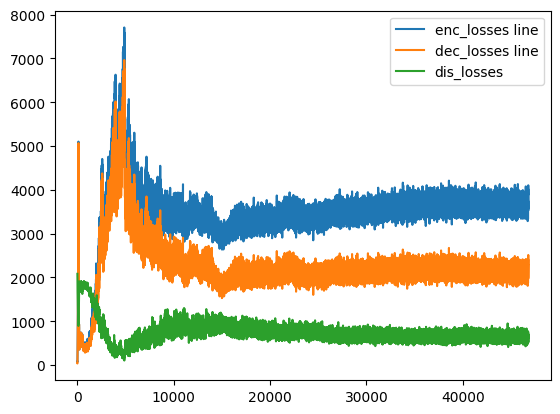

In [83]:
import matplotlib.pyplot as plt
plt.plot(enc_losses)
plt.plot(dec_losses)
plt.plot(dis_losses2)
plt.legend(['enc_losses line', 'dec_losses line','dis_losses'])

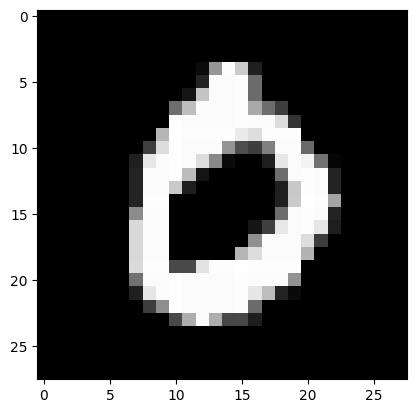

torch.Size([1, 784])


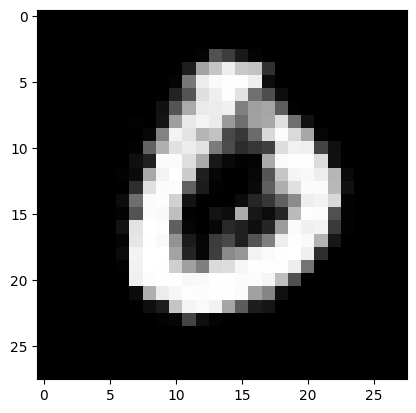

In [87]:
first_image = np.array(test_images[3], dtype=np.float32)
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()
first_image = first_image.reshape((1,784))
first_image = torch.from_numpy(first_image).cuda()
print(first_image.shape)
with torch.no_grad():
    mu, logvar = enc(first_image)      
    epsilon = torch.randn_like(mu).cuda()
    z = mu + epsilon * torch.exp(0.5*logvar)
    rec = dec(z)
    rec = rec.cpu().numpy()
rec = rec.reshape((28, 28))
plt.imshow(rec, cmap='gray')
plt.show()